# RNN Sine Wave

### Overview
Predict a simple sine wave using RNN

Adopted with thanks from [here](https://www.datatechnotes.com/2018/12/rnn-example-with-keras-simplernn-in.html)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ("tf version: ", tf.__version__)
print ("keras version: ", keras.__version__)

tf version:  2.3.0
keras version:  2.4.0


## TF-GPU Debug
The following block tests if TF is running on GPU.

In [2]:
print (tf.config.experimental.list_physical_devices())

## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# number formats
pd.options.display.float_format = '{:,.4f}'.format
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

## Generate some data

In [4]:
# Generate 1000 samples
samples = 1000    
training_samples = 800    

t=np.arange(0,samples)

## Generating a sine wave, with some noise 
x=np.sin(0.02*t)+2*np.random.rand(samples)

## print data
df_orig = pd.DataFrame(x)
df_orig


,0
0,1.9239
1,0.1661
2,0.3281
3,1.9848
4,0.7335
...,...
995,1.3410
996,1.5441
997,1.2833
998,2.3653


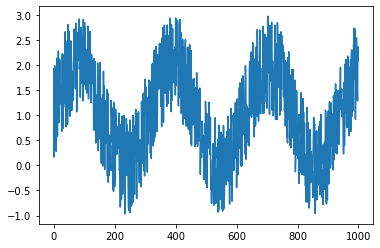

In [5]:
## plot data
plt.plot(df_orig)
plt.show() 

## Train / Test split

In [6]:
## Create train / test values

values=df_orig.values
train,test = values[0:training_samples,:], values[training_samples:samples,:]

print ("values:" , values[1:20])
print ('train size', len(train))
print ('test size', len(test))

values: [[ 0.1661]
 [ 0.3281]
 [ 1.9848]
 [ 0.7335]
 [ 0.6048]
 [ 0.4135]
 [ 1.8930]
 [ 0.2787]
 [ 0.9715]
 [ 2.1354]
 [ 1.1811]
 [ 0.5782]
 [ 1.4726]
 [ 1.7918]
 [ 2.2741]
 [ 1.9895]
 [ 0.8487]
 [ 1.3431]
 [ 2.1118]]
train size 800
test size 200


In [7]:
## padding the data
step = 4
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

print ("train size", len(train))
print ("test size", len(test))

train size 804
test size 204


In [8]:
## see some data
## compare with original data
train[:30]

array([ 1.9239,  0.1661,  0.3281,  1.9848,  0.7335,  0.6048,  0.4135,
        1.8930,  0.2787,  0.9715,  2.1354,  1.1811,  0.5782,  1.4726,
        1.7918,  2.2741,  1.9895,  0.8487,  1.3431,  2.1118,  2.0897,
        1.2288,  1.3781,  1.3675,  1.5750,  1.1348,  0.6785,  1.5589,
        2.2224,  1.0507])

In [9]:
## vectorize the data

def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

x_train,y_train =convertToMatrix(train,step)
x_test,y_test =convertToMatrix(test,step)

print ("x_train.shape", x_train.shape)
print ("y_train.shape", y_train.shape)
print ("x_test.shape", x_test.shape)
print ("y_test.shape", y_test.shape)

x_train.shape (800, 4)
y_train.shape (800,)
x_test.shape (200, 4)
y_test.shape (200,)


In [10]:
## See data
df = pd.DataFrame(x_train, y_train)
df

,0,1,2,3
0.7335,1.9239,0.1661,0.3281,1.9848
0.6048,0.1661,0.3281,1.9848,0.7335
0.4135,0.3281,1.9848,0.7335,0.6048
1.8930,1.9848,0.7335,0.6048,0.4135
0.2787,0.7335,0.6048,0.4135,1.8930
...,...,...,...,...
0.6862,0.7716,0.2073,1.4872,0.7171
0.6862,0.2073,1.4872,0.7171,0.6862
0.6862,1.4872,0.7171,0.6862,0.6862
0.6862,0.7171,0.6862,0.6862,0.6862


In [11]:
## Finally, we'll reshape trainX and testX to fit with the Keras model. 
## RNN model requires three-dimensional input data.

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print ("x_train.shape", x_train.shape)
print ("y_train.shape", y_train.shape)
print ("x_test.shape", x_test.shape)
print ("y_test.shape", y_test.shape)

x_train.shape (800, 1, 4)
y_train.shape (800,)
x_test.shape (200, 1, 4)
y_test.shape (200,)


## Build RNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1184      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


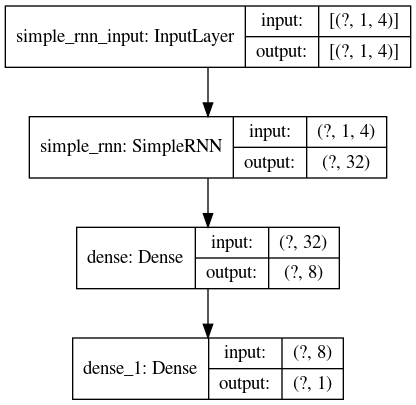

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(keras.layers.Dense(8, activation="relu")) 
model.add(keras.layers.Dense(1))
model.compile(optimizer='rmsprop', loss = 'mse', metrics=['mse'])
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Setup Tensorboard

In [13]:
## This is fairly boiler plate code

import datetime
import os
import shutil

app_name = 'rnn-sine'

# timestamp  = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

tb_top_level_dir= '/tmp/tensorboard-logs'

tb_app_dir = os.path.join (tb_top_level_dir, app_name)

tb_logs_dir = os.path.join (tb_app_dir, datetime.datetime.now().strftime("%H-%M-%S"))


print ("Saving TB logs to : " , tb_logs_dir)

#clear out old logs
shutil.rmtree ( tb_app_dir, ignore_errors=True )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_logs_dir, write_graph=True, 
                                                      write_images=True, histogram_freq=1)

## This will embed Tensorboard right here in jupyter!
%load_ext tensorboard
%tensorboard --logdir $tb_logs_dir

Saving TB logs to :  /tmp/tensorboard-logs/rnn-sine/19-49-39


## Train

In [14]:
%%time

print ("training starting ...")

# Fitting the RNN to the Training set
history = model.fit(x_train, y_train, epochs=100, batch_size=16,
                   callbacks = [tensorboard_callback])

print ("training done.")

training starting ...
Epoch 1/100
 1/50 [..............................] - ETA: 0s - loss: 1.6943 - mse: 1.6943WARNING:tensorflow:From /home/sujee/anaconda3/envs/tf-2.3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
50/50 [==============================] - 0s 2ms/step - loss: 0.8742 - mse: 0.8742
Epoch 2/100
50/50 [==============================] - 0s 1ms/step - loss: 0.4709 - mse: 0.4709
Epoch 3/100
50/50 [==============================] - 0s 1ms/step - loss: 0.4356 - mse: 0.4356
Epoch 4/100
50/50 [==============================] - 0s 1ms/step - loss: 0.4234 - mse: 0.4234
Epoch 5/100
50/50 [==============================] - 0s 1ms/step - loss: 0.4180 - mse: 0.4180
Epoch 6/100
50/50 [==============================] - 0s 1ms/step - loss: 0.4162 - mse: 0.4162
Epoch 7/100
50/50 [=================

## Training History

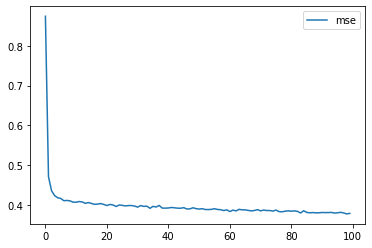

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='mse')
plt.legend()
plt.show()

## Prediction

In [16]:
predict_train = model.predict(x_train)
predict_test= model.predict(x_test)

predicted=np.concatenate((predict_train,predict_test),axis=0)

print (predicted[:10])


[[ 0.7558]
 [ 0.6884]
 [ 1.1440]
 [ 1.2529]
 [ 1.0287]
 [ 1.0514]
 [ 1.0955]
 [ 1.1676]
 [ 0.9688]
 [ 1.3966]]


## Evaluate

In [17]:
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)

print ("train_score", train_score)
print ("test_score", test_score)

train_score [0.3782018721103668, 0.3782018721103668]
test_score [0.38556796312332153, 0.38556796312332153]


In [18]:
metric_names = model.metrics_names
print ("model metrics : " , metric_names)

train_metrics = model.evaluate(x_train, y_train, verbose=0)
for idx, metric in enumerate(metric_names):
    print ("Train Metric : {} = {:,.2f}".format (metric_names[idx], train_metrics[idx]))
    
test_metrics = model.evaluate(x_test, y_test, verbose=0)
for idx, metric in enumerate(metric_names):
    print ("Test Metric : {} = {:,.2f}".format (metric_names[idx], test_metrics[idx]))

model metrics :  ['loss', 'mse']
Train Metric : loss = 0.38
Train Metric : mse = 0.38
Test Metric : loss = 0.39
Test Metric : mse = 0.39


## Plot

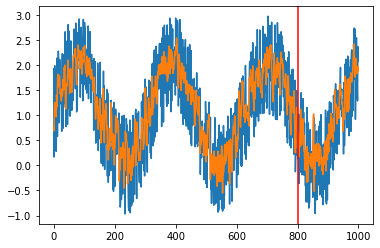

In [19]:
index = df_orig.index.values
plt.plot(df_orig)
plt.plot(predicted)
plt.axvline(df_orig.index[training_samples], c="r")
plt.show()